In [1]:
%load_ext autoreload

In [2]:
import os

import torch
from torch import nn
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

os.chdir('..')
!export PYTHONPATH=$(pwd):$PYTHONPATH
import parkinson

In [3]:
RDN = 50
N_CLASSES = 2
BATCH_SIZE = 64
N_EPOCHS = 200
PATIENCE = 20
LR = 0.0001
DECAY = 0.000001
SAVE_PATH = 'outputs/3_timeseries'

# Data Processing

In [4]:
# Reading data from files.
print('Started file reading...')
parkinson_data = parkinson.utils.data.batch_read('data/PDs_columns')
control_data = parkinson.utils.data.batch_read('data/Controls_columns')
print('File reading completed.')

# Selecting the atlas (brain division strategy: Shen_268 or atlas or AAL3).
control_atlas_data = parkinson.utils.data.select_atlas_columns(control_data, 'AAL3')
parkinson_atlas_data = parkinson.utils.data.select_atlas_columns(parkinson_data, 'AAL3')

# Turning the selected data in time series (shape = [n_pacientes, n_channels, n_observations]).
control_ts_data = parkinson.utils.data.df_to_timeseries(control_atlas_data)
parkinson_ts_data = parkinson.utils.data.df_to_timeseries(parkinson_atlas_data)

# Mixing Control/Parkinson pacients and changing NaN values to zero.
X = parkinson.utils.data.concatenate_data(parkinson_ts_data, control_ts_data)
y = parkinson.utils.data.concatenate_data([1 for _ in range(len(parkinson_data))], [0 for _ in range(len(control_data))])
X, y = parkinson.utils.data.filter_data(X, y)

# Spliting data into 60 train, 20 validation and 20 test.
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=RDN, stratify=y, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.25, random_state=RDN, stratify=y_trainval, shuffle=True)

# Applying Oversampling in the train set.
orig_shape = X_train.shape
X_train = X_train.reshape(X_train.shape[0], -1)

smote = SMOTE(random_state=RDN)
X_train, y_train = smote.fit_resample(X_train, y_train)

X_train = X_train.reshape(-1, *orig_shape[1:])

# Creating DataLoader
train_loader = parkinson.utils.data.get_torch_dataloader(X_train, y_train, batch_size=BATCH_SIZE)
val_loader = parkinson.utils.data.get_torch_dataloader(X_val, y_val, batch_size=BATCH_SIZE)
test_loader = parkinson.utils.data.get_torch_dataloader(X_test, y_test, batch_size=BATCH_SIZE)

Started file reading...


100%|██████████| 66/66 [00:01<00:00, 43.46it/s]


File reading completed.


# Training

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = parkinson.NetworkModels.tsFCN(X_train.shape[1], N_CLASSES)

model.train()
criterion = nn.CrossEntropyLoss()

out = parkinson.utils.train.train(model, train_loader, val_loader, device, N_EPOCHS, PATIENCE, LR, DECAY)

metrics = parkinson.utils.train.evaluate(model, test_loader, device)

Epoch:   0%|          | 0/200 [00:00<?, ?it/s]/home/labic/miniconda3/envs/eniac/lib/python3.12/site-packages/torch/nn/modules/conv.py:370: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1036.)
  return F.conv1d(
train-loss: 0.0387  train-acc: 1.0000 | val-loss: 0.8452  val-acc: 0.6591:  10%|█         | 20/200 [00:09<01:27,  2.06it/s]

Early stopping at epoch 21


# Result Analysis

 Acurácia       F1  Precisão   Recall
 0.545455 0.560084   0.58269 0.545455


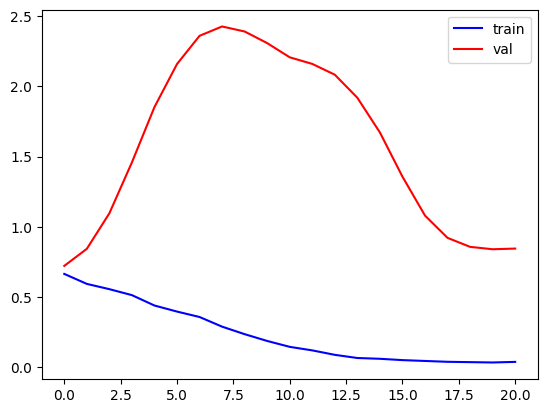

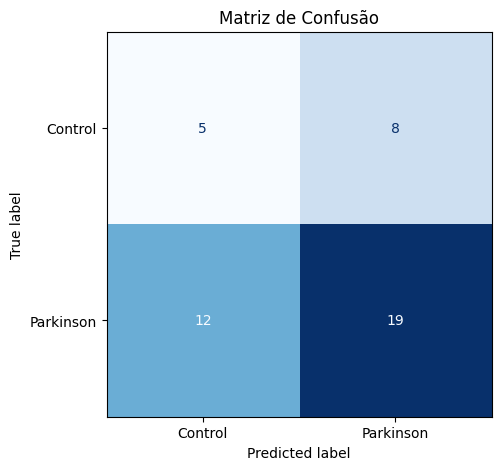

In [6]:
# Criando e plotando os resultados.
parkinson.utils.results.metrics_to_dataframe(metrics)
fig_loss = parkinson.utils.results.plot_losses(out['train_loss'],out['val_loss'])
fig_loss.show()
fig_cf = parkinson.utils.results.plot_confusion_matrix(metrics['preds'], metrics['labels'], class_names=['Control','Parkinson'])
fig_cf.show()

# Salvando as figuras.
fig_loss.savefig(f"{SAVE_PATH}/loss_curve.png", bbox_inches='tight')
fig_cf.savefig(f"{SAVE_PATH}/confusion_matrix.png", bbox_inches='tight')